In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.datasets import load_breast_cancer 
from sklearn import decomposition, datasets
from sklearn.svm import SVC, SVR
import os, sys
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch
from torchvision import models
import datetime

In [ ]:
!pip install roboflow

from roboflow import Roboflow 
rf = Roboflow(api_key="DXb4B94A1xpmpoSfBs45")
project = rf.workspace("itml-project").project("itml-final-project-ai-versus-non-ai-dataset")
dataset = project.version(4).download("folder")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 138 kB 67.0 MB/s 
     |████████████████████████████████| 178 kB 48.7 MB/s 
     |████████████████████████████████| 67 kB 4.0 MB/s 
     |████████████████████████████████| 145 kB 77.0 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=0a1babd6d46fb2af6e9cfe13caeff109de87830647c6666f752d840a34b4032b
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certi

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ITML-Final-Project-AI-versus-Non-AI-Dataset-4 in folder:: 100%|██████████| 1900/1900 [00:01<00:00, 1664.22it/s]


In [ ]:
data_loc= dataset.location

In [ ]:
preprocess = transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor()
])

In [ ]:
from torchvision.datasets import ImageFolder
ai_train = data_loc + '/train'
ai_val = data_loc + '/valid'
ai_train_set = ImageFolder(ai_train,transform = preprocess)
ai_val_set = ImageFolder(ai_val, transform = preprocess)

In [ ]:
ai_test = ImageFolder(ai_train)

In [ ]:

imgs = torch.stack([img_t for img_t, _ in ai_train_set], dim=3)
imgs.shape

torch.Size([3, 512, 512, 1318])

In [ ]:
imgs.view(3, -1).mean(dim=1)  # <1>

tensor([0.4758, 0.4473, 0.3603])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2669, 0.2644, 0.2747])

In [ ]:
preprocess2 = transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.4758, 0.4473, 0.3603],
        std=[0.2669, 0.2644, 0.2747])
])

In [ ]:
ai_train_set = ImageFolder(ai_train,transform = preprocess2)
ai_val_set = ImageFolder(ai_val, transform = preprocess2)

In [ ]:
model = models.resnet34(weights = False)

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print('{} Epoch {}, Training loss {}'.format(
    datetime.datetime.now(), epoch,
    loss_train / len(train_loader)))

In [ ]:
def validate(model, train_loader, val_loader):
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0
    with torch.no_grad():
      for imgs, labels in loader:
          imgs, labels = imgs.to(device), labels.to(device)
          batchsize = imgs.shape[0]
          outputs = model(imgs)
          _, predicted = torch.max(outputs, dim=1)
          total += labels.shape[0]
          correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name , correct / total))

In [ ]:
train_loader = torch.utils.data.DataLoader(ai_train_set, batch_size=64,
                                           shuffle=True)  # <1>

model = model.to(device=device)  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-3)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-12-12 20:56:21.137805 Epoch 1, Training loss 5.278420868374052
2022-12-12 20:57:02.372164 Epoch 2, Training loss 1.8928487357639132
2022-12-12 20:57:42.666725 Epoch 3, Training loss 0.8871191626503354
2022-12-12 20:58:23.760189 Epoch 4, Training loss 0.7243469726471674
2022-12-12 20:59:05.518663 Epoch 5, Training loss 0.6538326569965908
2022-12-12 20:59:48.532157 Epoch 6, Training loss 0.6044941828364417
2022-12-12 21:00:30.071058 Epoch 7, Training loss 0.559759049188523
2022-12-12 21:01:12.068584 Epoch 8, Training loss 0.5236425002415975
2022-12-12 21:01:51.133713 Epoch 9, Training loss 0.48180323129608515
2022-12-12 21:02:30.285475 Epoch 10, Training loss 0.4569794918809618


In [ ]:
train_loader = torch.utils.data.DataLoader(ai_train_set, batch_size=64,
                                           shuffle=False)  # <1>
val_loader = torch.utils.data.DataLoader(ai_val_set, batch_size=64,
                                           shuffle=False)  # <1>

validate(model, train_loader, val_loader)

Accuracy train: 0.51
Accuracy val: 0.51


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_loader:
        inputs=inputs.to(device); labels=labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).cpu().detach().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().detach().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('nonai','AI')

In [ ]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


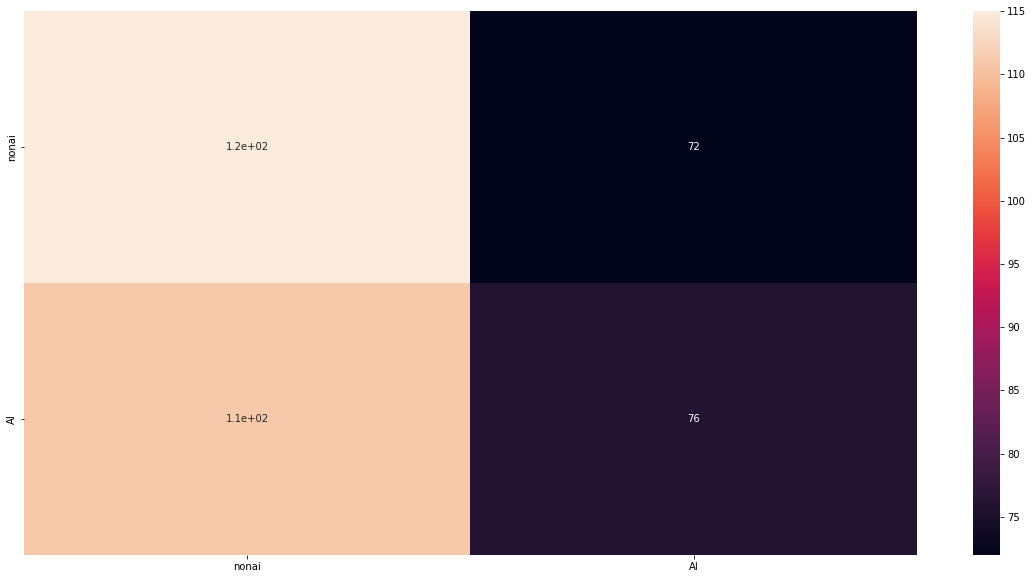

In [ ]:
# Build confusion matrix
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)
plt.savefig('CnfMatrix_ResNet18_1.png')